# *Libraries*


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_tree

import matplotlib.pyplot as plt
import seaborn as sns

from piml.models import XGB1Classifier, XGB2Classifier
from piml import Experiment

from mapie.classification import MapieClassifier

import pickle

# *Functions*

In [41]:
def non_conformity_score_prob(model, X, y):

    """
    Compute non-conformity scores based on predicted probabilities for a given model.

    The non-conformity score is calculated as `1 - P(true_class)`, where `P(true_class)` 
    is the predicted probability of the true class for each sample. A lower predicted 
    probability for the true class indicates higher non-conformity.

    Parameters
    ----------
    model : object
        A trained classification model that implements the `predict_proba` method. 
        The model should output class probabilities for the input samples.
    
    X : array-like of shape (n_samples, n_features)
        The input data for which predictions are made.
    
    y : array-like of shape (n_samples,)
        The true labels corresponding to the input data. The labels should be 
        integers corresponding to class indices.
    
    Returns
    -------
    np.ndarray of shape (n_samples,)
        An array of non-conformity scores for each sample, where a higher score 
        indicates greater non-conformity to the model's predictions.

    Notes
    -----
    - This function assumes binary classification and that the `predict_proba` 
      method returns probabilities for two classes, with the probabilities 
      for each class ordered by their indices (0 and 1).
    - For multi-class classification, this function would need adjustments 
      to handle multiple classes.

    Examples
    --------
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> import numpy as np
    >>> X_train, X_test, y_train, y_test = ...  # Load or generate data
    >>> model = RandomForestClassifier().fit(X_train, y_train)
    >>> non_conformity_score_prob(model, X_test, y_test)
    array([0.2, 0.3, 0.1, ...])
    """


    # Predict probabilities
    y_pred_proba = model.predict_proba(X)
    
    # For binary classification
    # Take the probability of the true class
    scores = []
    for i, true_label in enumerate(y):
        # If true label is 1, take probability of class 1
        # If true label is 0, take probability of class 0
        score = y_pred_proba[i][true_label]
        
        # Transform to create non-conformity score
        # Lower probability = more non-conforming
        scores.append(1 - score)
    
    return np.array(scores)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [42]:
def calculate_prediction_interval_batch(model, X_cal, y_cal, X_new, significance_level=0.1):
    """
    Calculate conformal prediction sets for a batch of new observations.
    
    Parameters:
    - model: Trained classification model with `predict_proba` method.
    - X_cal: Calibration features.
    - y_cal: Calibration labels.
    - X_new: New batch of features for prediction.
    - significance_level: Significance level (alpha) for conformal prediction.
    
    Returns:
    - A dictionary containing:
        - prediction_sets: List of sets for each observation in X_new.
        - probabilities: Predicted probabilities for X_new.
        - scores: Non-conformity scores for X_new.
        - threshold: Calculated threshold for non-conformity scores.
    """
    # Step 1: Compute calibration scores
    calibration_scores = non_conformity_score_prob(model, X_cal, y_cal)
    
    # Step 2: Compute threshold
    threshold = np.quantile(calibration_scores, 1 - significance_level)
    
    # Step 3: Predict probabilities for the batch
    batch_proba = model.predict_proba(X_new)
    
    # Step 4: Determine prediction sets
    prediction_sets = (1 - batch_proba <= threshold).astype(int)  # Boolean mask for classes
    
    return {
        'prediction_sets': prediction_sets.tolist(),  # Convert to list for easy interpretation
        'probabilities': batch_proba,
        'scores': 1 - batch_proba,  # Non-conformity scores for all classes
        'threshold': threshold
    }


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

# *Import Datasets*

In [5]:
train_df = pd.read_csv('DATA/preprocessed_train.csv', low_memory=False)
valid_df = pd.read_csv('DATA/preprocessed_valid.csv', low_memory=False)
test_df = pd.read_csv('DATA/preprocessed_test.csv', low_memory=False)

In [6]:
train_df.shape, valid_df.shape, test_df.shape

((20745, 11), (5187, 11), (6484, 11))

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20745 entries, 0 to 20744
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_income               20745 non-null  float64
 1   person_home_ownership       20745 non-null  int64  
 2   person_emp_length           20745 non-null  float64
 3   loan_intent                 20745 non-null  int64  
 4   loan_grade                  20745 non-null  int64  
 5   loan_amnt                   20745 non-null  int64  
 6   loan_status                 20745 non-null  int64  
 7   loan_percent_income         20745 non-null  float64
 8   cb_person_default_on_file   20745 non-null  int64  
 9   cb_person_cred_hist_length  20745 non-null  int64  
 10  ID                          20745 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.7 MB


# *Data Preparation for Modeling*

In [8]:
modeling_variables = ['person_income', 'person_home_ownership', 'person_emp_length',
       'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length']

target_variable = 'loan_status'

In [9]:
# Take necessary columns

# Train
X_train = train_df[modeling_variables]
y_train = train_df[target_variable]

# Validation
X_valid = valid_df[modeling_variables]
y_valid = valid_df[target_variable]

# Test
X_test = test_df[modeling_variables]
y_test = test_df[target_variable]

# *Modeling*

In [10]:
# Define monotonicity constraints
mono_increasing_list = ['person_home_ownership', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_percent_income', 'cb_person_default_on_file']
mono_decreasing_list = ['person_income', 'person_emp_length', 'cb_person_cred_hist_length']

**XGB1Classifier**

XGBoost model with depth 1, captures only main effect

In [10]:
# Create the model
xgb1 = XGB1Classifier(mono_increasing_list=mono_increasing_list, mono_decreasing_list=mono_decreasing_list, n_estimators=200, eta=0.1,
                      random_state=42)

In [11]:
# Fit the model
xgb1.fit(X_train, y_train)

XGB1Classifier(eta=0.1,
               mono_decreasing_list=['person_income', 'person_emp_length',
                                     'cb_person_cred_hist_length'],
               mono_increasing_list=['person_home_ownership', 'loan_intent',
                                     'loan_grade', 'loan_amnt',
                                     'loan_percent_income',
                                     'cb_person_default_on_file'],
               n_estimators=200, random_state=42)

In [12]:
# Predict
pred_train = xgb1.predict_proba(X_train)[:, 1]
pred_valid = xgb1.predict_proba(X_valid)[:, 1]
pred_test = xgb1.predict_proba(X_test)[:, 1]

In [13]:
# Calculate AUC
print('AUC Train:', roc_auc_score(y_train, pred_train))
print('AUC Valid:', roc_auc_score(y_valid, pred_valid))
print('AUC Test:', roc_auc_score(y_test, pred_test))

AUC Train: 0.8400131559879183
AUC Valid: 0.841888295516942
AUC Test: 0.8433534464850043


**XGB2Classifier**

XGBoost model with depth 2, captures main effect of the feature as well as pariwise contribution of features

In [14]:
# Create the model
xgb2 = XGB2Classifier(mono_increasing_list=mono_increasing_list, mono_decreasing_list=mono_decreasing_list, 
                      n_estimators=50, eta=0.3, feature_names=modeling_variables,
                      random_state=42)

In [16]:
# Fit the model
xgb2.fit(X_train, y_train)

XGB2Classifier(feature_names=['person_income', 'person_home_ownership',
                              'person_emp_length', 'loan_intent', 'loan_grade',
                              'loan_amnt', 'loan_percent_income',
                              'cb_person_default_on_file',
                              'cb_person_cred_hist_length'],
               mono_decreasing_list=['person_income', 'person_emp_length',
                                     'cb_person_cred_hist_length'],
               mono_increasing_list=['person_home_ownership', 'loan_intent',
                                     'loan_grade', 'loan_amnt',
                                     'loan_percent_income',
                                     'cb_person_default_on_file'],
               n_estimators=50, random_state=42)

In [17]:
# Predict
pred_train = xgb2.predict_proba(X_train)[:, 1]
pred_valid = xgb2.predict_proba(X_valid)[:, 1]
pred_test = xgb2.predict_proba(X_test)[:, 1]

In [18]:
# Calculate AUC
print('AUC Train:', roc_auc_score(y_train, pred_train))
print('AUC Valid:', roc_auc_score(y_valid, pred_valid))
print('AUC Test:', roc_auc_score(y_test, pred_test))

AUC Train: 0.9147460697121819
AUC Valid: 0.9221885682909117
AUC Test: 0.9182831440556816


In [20]:
# Modell efects
parsed_model = xgb2.parse_model()
list(zip(parsed_model.effect_names_, parsed_model.effect_types_))

[('person_income', 'numerical'),
 ('loan_grade', 'numerical'),
 ('person_home_ownership', 'numerical'),
 ('loan_intent', 'numerical'),
 ('loan_amnt', 'numerical'),
 ('loan_percent_income', 'numerical'),
 ('cb_person_cred_hist_length', 'numerical'),
 ('person_emp_length', 'numerical'),
 ('person_income x person_home_ownership', 'pairwise'),
 ('person_income x loan_intent', 'pairwise'),
 ('person_income x loan_grade', 'pairwise'),
 ('person_income x loan_amnt', 'pairwise'),
 ('person_income x loan_percent_income', 'pairwise'),
 ('person_income x cb_person_cred_hist_length', 'pairwise'),
 ('person_home_ownership x loan_intent', 'pairwise'),
 ('person_home_ownership x loan_grade', 'pairwise'),
 ('person_home_ownership x loan_amnt', 'pairwise'),
 ('person_home_ownership x loan_percent_income', 'pairwise'),
 ('person_emp_length x loan_grade', 'pairwise'),
 ('loan_intent x loan_grade', 'pairwise'),
 ('loan_intent x loan_amnt', 'pairwise'),
 ('loan_intent x loan_percent_income', 'pairwise'),
 

# *Hyperparameter Tuning*

In [517]:
# Model Objcet
xgb2 = XGB2Classifier(mono_increasing_list=mono_increasing_list, mono_decreasing_list=mono_decreasing_list, 
                    feature_names=modeling_variables)

# Parameter Grid
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 150, 200],
    'tree_method' : ['auto', 'exact', 'approx', 'hist'],
    'max_bin' : [20, 100, 256, 512]
}

# Grid Search Object
grid_search = GridSearchCV(xgb2, param_grid, cv=5, n_jobs=-1, verbose=True, scoring='roc_auc', return_train_score=True)


grid_search.fit(X_train, y_train)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=XGB2Classifier(feature_names=['person_income',
                                                     'person_home_ownership',
                                                     'person_emp_length',
                                                     'loan_intent',
                                                     'loan_grade', 'loan_amnt',
                                                     'loan_percent_income',
                                                     'cb_person_default_on_file',
                                                     'cb_person_cred_hist_length'],
                                      mono_decreasing_list=['person_income',
                                                            'person_emp_length',
                                                            'cb_person_cred_hist_length'],
                                      mono_increasing_list=['person_home_ownership',
                                                            'loan_intent',
                                                            'loan_grade',
                                                            'loan_amnt',
                                                            'loan_percent_income',
                                                            'cb_person_default_on_file']),
             n_jobs=-1,
             param_grid={'eta': [0.01, 0.1, 0.3],
                         'max_bin': [20, 100, 256, 512],
                         'n_estimators': [50, 100, 150, 200],
                         'tree_method': ['auto', 'exact', 'approx', 'hist']},
             return_train_score=True, scoring='roc_auc', verbose=True)

In [518]:
print("Best Parameters:", grid_search.best_params_)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Best Parameters: {'eta': 0.3, 'max_bin': 256, 'n_estimators': 100, 'tree_method': 'auto'}


In [519]:
cv_results = pd.DataFrame(grid_search.cv_results_)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [520]:
cv_results.head()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_bin,param_n_estimators,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.116941,0.007248,0.013401,0.002381,0.01,20,50,auto,"{'eta': 0.01, 'max_bin': 20, 'n_estimators': 50, 'tree_method': 'auto'}",0.830551,0.821388,0.825637,0.824176,0.831019,0.826554,0.003717,178,0.825212,0.829813,0.826428,0.826802,0.825065,0.826664,0.001712
1,0.365262,0.021686,0.016006,0.003754,0.01,20,50,exact,"{'eta': 0.01, 'max_bin': 20, 'n_estimators': 50, 'tree_method': 'exact'}",0.830554,0.820629,0.826834,0.822844,0.828518,0.825876,0.003647,180,0.826477,0.829376,0.825343,0.826351,0.824904,0.826490,0.001561
2,0.626807,0.015221,0.011622,0.001542,0.01,20,50,approx,"{'eta': 0.01, 'max_bin': 20, 'n_estimators': 50, 'tree_method': 'approx'}",0.830680,0.824160,0.827900,0.826471,0.833588,0.828560,0.003284,177,0.827090,0.830781,0.827781,0.829547,0.827776,0.828595,0.001363
3,0.150950,0.027832,0.017027,0.007689,0.01,20,50,hist,"{'eta': 0.01, 'max_bin': 20, 'n_estimators': 50, 'tree_method': 'hist'}",0.830551,0.821388,0.825637,0.824176,0.831019,0.826554,0.003717,178,0.825212,0.829813,0.826428,0.826802,0.825065,0.826664,0.001712
4,0.191778,0.003609,0.014057,0.003015,0.01,20,100,auto,"{'eta': 0.01, 'max_bin': 20, 'n_estimators': 100, 'tree_method': 'auto'}",0.868018,0.869094,0.879165,0.874216,0.875425,0.873184,0.004130,175,0.873216,0.873396,0.876874,0.873736,0.877240,0.874892,0.001779


In [521]:
cv_results = cv_results[['params', 'mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score', 'rank_test_score']].sort_values('mean_test_score', ascending=False, ignore_index=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [522]:
cv_results.head(10)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,params,mean_test_score,mean_train_score,std_test_score,std_train_score,rank_test_score
0,"{'eta': 0.3, 'max_bin': 256, 'n_estimators': 100, 'tree_method': 'hist'}",0.912771,0.916372,0.003395,0.000780,1
1,"{'eta': 0.3, 'max_bin': 256, 'n_estimators': 100, 'tree_method': 'auto'}",0.912771,0.916372,0.003395,0.000780,1
2,"{'eta': 0.3, 'max_bin': 256, 'n_estimators': 150, 'tree_method': 'auto'}",0.912771,0.916372,0.003396,0.000779,3
3,"{'eta': 0.3, 'max_bin': 256, 'n_estimators': 150, 'tree_method': 'hist'}",0.912771,0.916372,0.003396,0.000779,3
4,"{'eta': 0.3, 'max_bin': 256, 'n_estimators': 200, 'tree_method': 'auto'}",0.912771,0.916372,0.003396,0.000779,3
5,"{'eta': 0.3, 'max_bin': 256, 'n_estimators': 200, 'tree_method': 'hist'}",0.912771,0.916372,0.003396,0.000779,3
6,"{'eta': 0.3, 'max_bin': 512, 'n_estimators': 150, 'tree_method': 'auto'}",0.912687,0.916463,0.003448,0.001155,7
7,"{'eta': 0.3, 'max_bin': 512, 'n_estimators': 200, 'tree_method': 'hist'}",0.912687,0.916463,0.003448,0.001155,7
8,"{'eta': 0.3, 'max_bin': 512, 'n_estimators': 150, 'tree_method': 'hist'}",0.912687,0.916463,0.003448,0.001155,7
9,"{'eta': 0.3, 'max_bin': 512, 'n_estimators': 200, 'tree_method': 'auto'}",0.912687,0.916463,0.003448,0.001155,7


I decided to choose ranked as 1 model with features {'eta': 0.3, 'max_bin': 10, 'n_estimators': 100, 'tree_method': 'exact'} model, because it is simple and the performance is almost the similar to the best model (max_bin doesn't have effect while we use 'tree_method' = 'exact')

# *Final model*

In [21]:
# Define final model

model = XGB2Classifier(mono_increasing_list=mono_increasing_list, mono_decreasing_list=mono_decreasing_list,
                        feature_names=modeling_variables, eta=0.3, max_depth=2, n_estimators=100, tree_method='exact',
                          random_state=42)

model.fit(X_train, y_train)

XGB2Classifier(feature_names=['person_income', 'person_home_ownership',
                              'person_emp_length', 'loan_intent', 'loan_grade',
                              'loan_amnt', 'loan_percent_income',
                              'cb_person_default_on_file',
                              'cb_person_cred_hist_length'],
               mono_decreasing_list=['person_income', 'person_emp_length',
                                     'cb_person_cred_hist_length'],
               mono_increasing_list=['person_home_ownership', 'loan_intent',
                                     'loan_grade', 'loan_amnt',
                                     'loan_percent_income',
                                     'cb_person_default_on_file'],
               random_state=42, tree_method='exact')

In [37]:
# Save the model
pickle.dump(model, open('xgb2_model.pkl', 'wb'))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [11]:
# Load the model
model = pickle.load(open('xgb2_model.pkl', 'rb'))

In [12]:
# Predict
pred_train = model.predict_proba(X_train)[:, 1]
pred_valid = model.predict_proba(X_valid)[:, 1]
pred_test = model.predict_proba(X_test)[:, 1]

In [13]:
# Calculate AUC
print('AUC Train:', roc_auc_score(y_train, pred_train))
print('AUC Valid:', roc_auc_score(y_valid, pred_valid))
print('AUC Test:', roc_auc_score(y_test, pred_test))

AUC Train: 0.915409151034891
AUC Valid: 0.9219390421028393
AUC Test: 0.9171277240314093


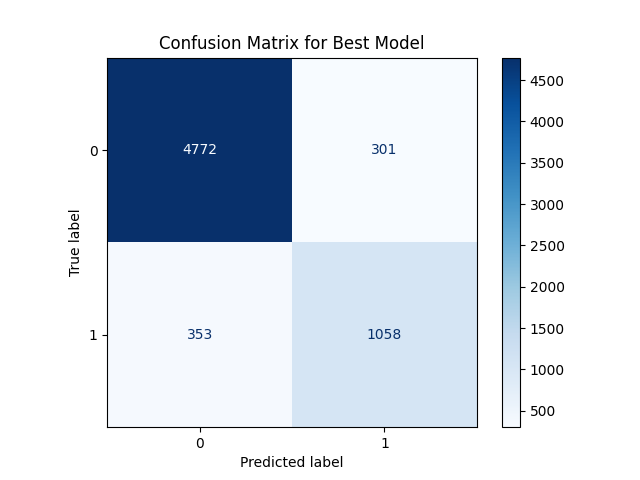

In [14]:
# Confusion Matrix

pred_test = model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, (pred_test>0.3).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Best Model')
plt.show()

In [15]:
# precision indicates how many of the samples predicted as positive are actually positive
# recall indicates how many of the actual positive samples are correctly predicted as positive

print('Precision:', round(precision_score(y_test, (pred_test>0.3).astype(int)),2))
print('Recall:', round(recall_score(y_test, (pred_test>0.3).astype(int)),2))

Precision: 0.78
Recall: 0.75


# *Model Exploration/Interpretation*

In [16]:
exp = Experiment()
pipeline = exp.make_pipeline(model=model, train_x=X_train, train_y=y_train.ravel(),
                             test_x=X_test, test_y=y_test.ravel(), feature_names=modeling_variables)

exp.register(pipeline, "XGB2")

In [17]:
modeling_variables

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

['person_income',
 'person_home_ownership',
 'person_emp_length',
 'loan_intent',
 'loan_grade',
 'loan_amnt',
 'loan_percent_income',
 'cb_person_default_on_file',
 'cb_person_cred_hist_length']

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

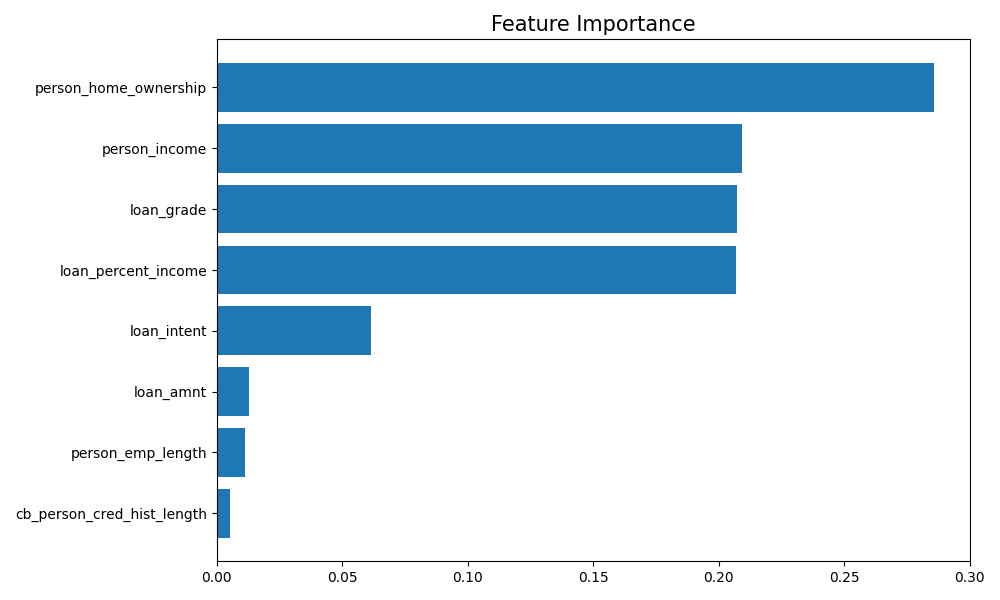

In [67]:
# Feature Importance
exp.model_interpret(model='XGB2', show="global_fi", figsize=(10, 6), original_scale=True)   

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

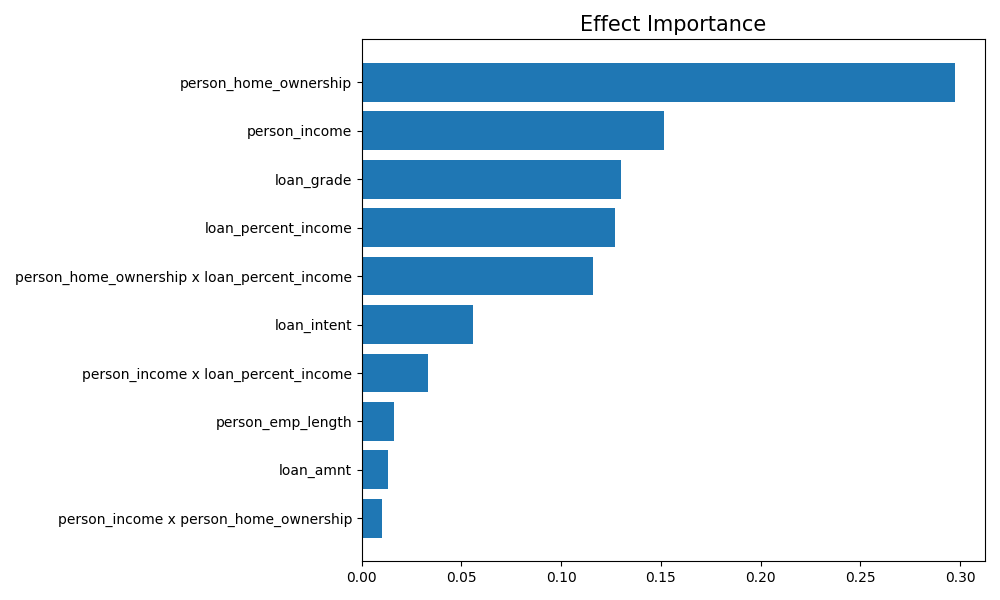

In [19]:
# Effect Importance , caluclated by normalized variances
exp.model_interpret(model='XGB2', show="global_ei", figsize=(10, 6), original_scale=True)   

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

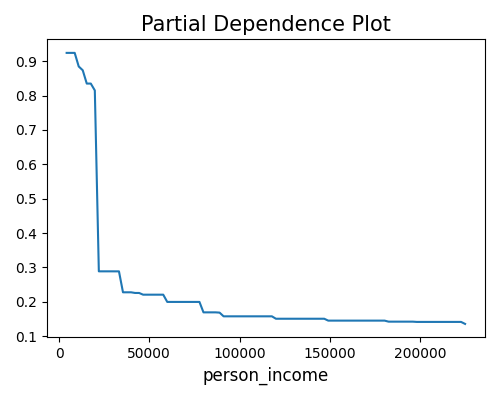

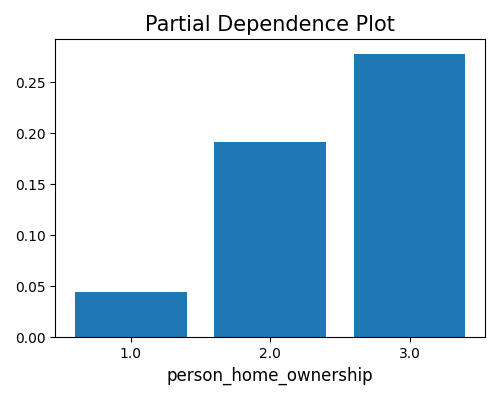

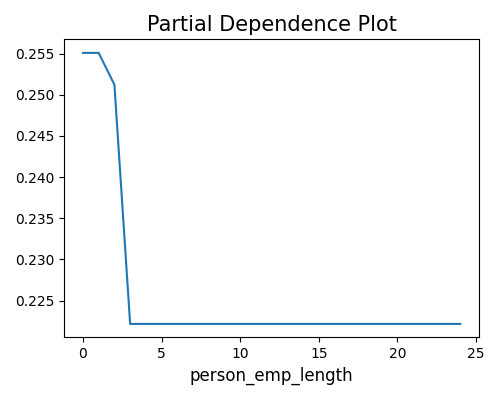

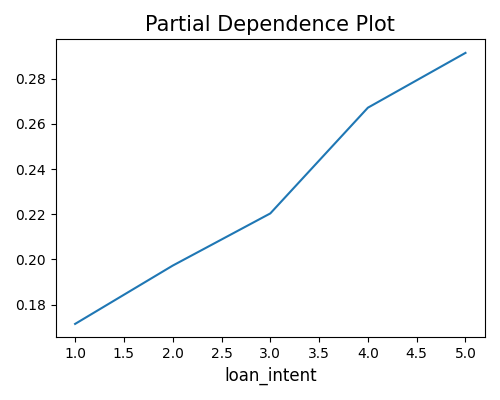

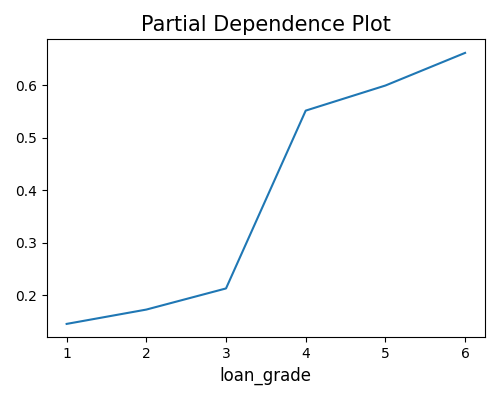

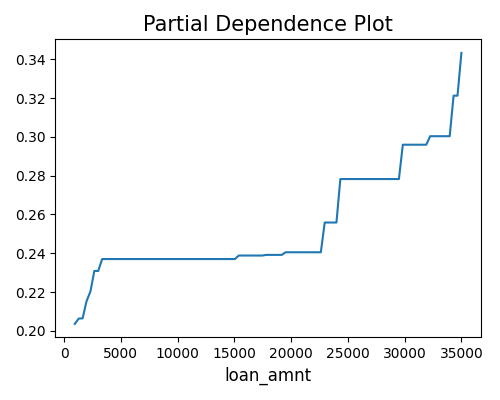

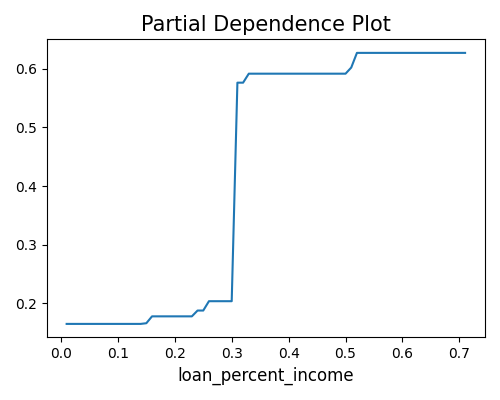

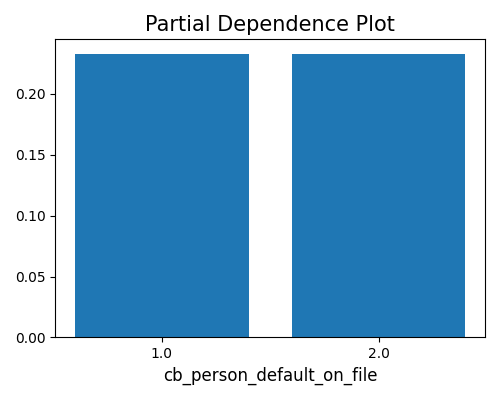

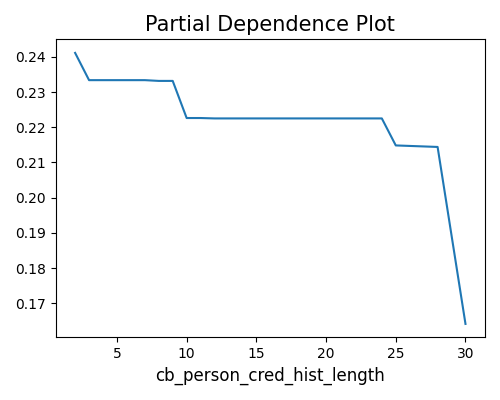

In [31]:
# Compute PDP for all features
for feature in modeling_variables:
    exp.model_explain(model="XGB2", show="pdp", uni_feature=feature, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

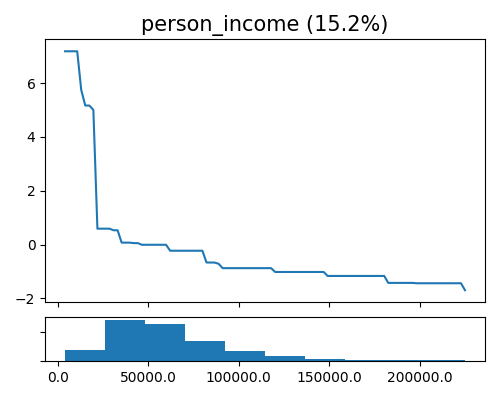

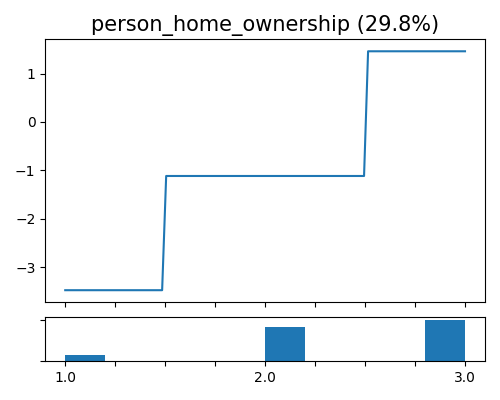

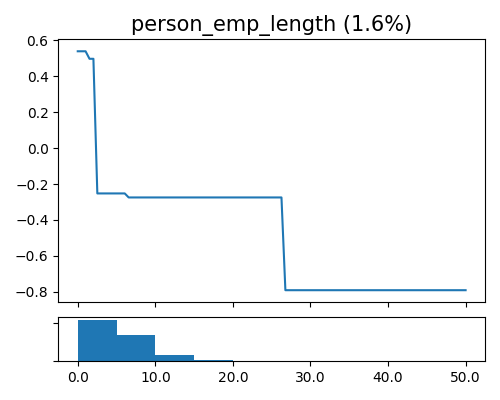

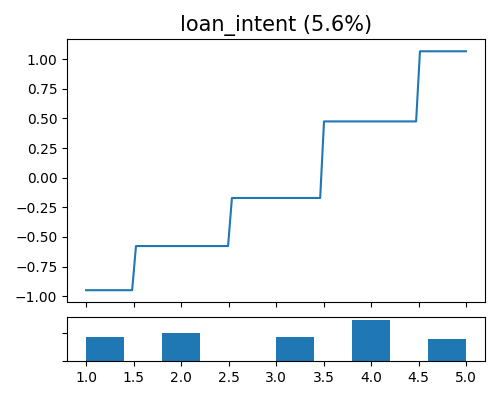

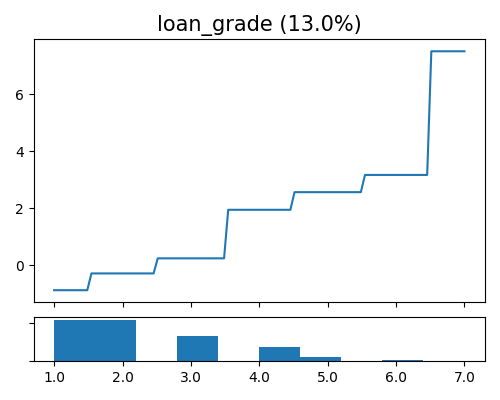

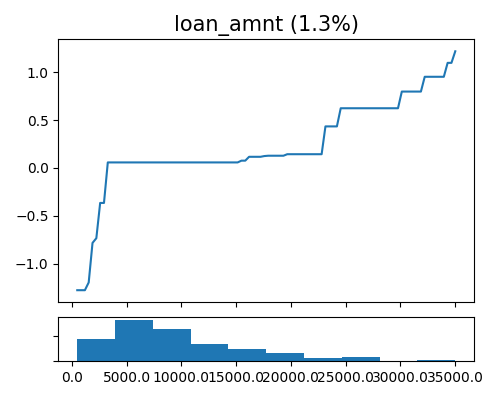

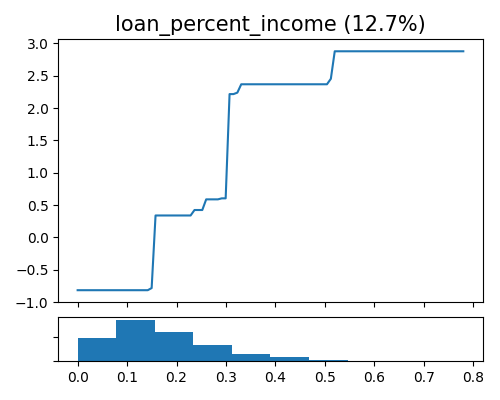

HTML(value="<p class='notification error'>This main effect does not exist.</p>")

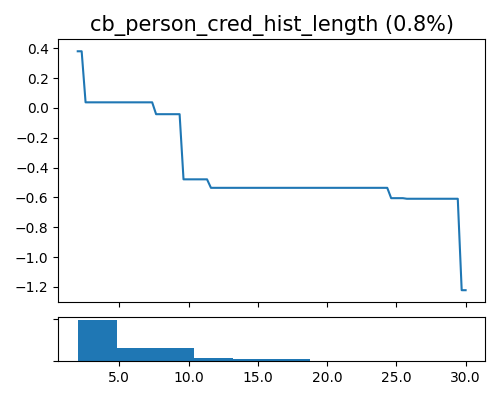

In [32]:
# Compute effects for all features
for feature in modeling_variables:
    exp.model_interpret(model='XGB2', show="global_effect_plot", uni_feature=feature, original_scale=True, figsize=(5, 4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

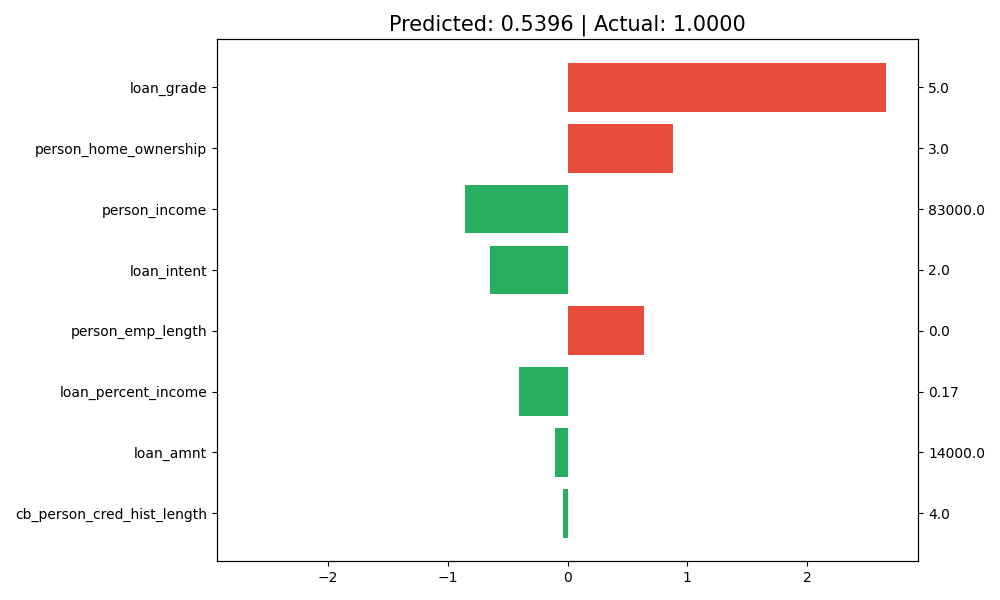

In [64]:
# Compute each features's effect in the final output for on sample
exp.model_interpret(model='XGB2', show="local_fi", figsize=(10, 6), original_scale=True, sample_id=1)

**Additional exploration**

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

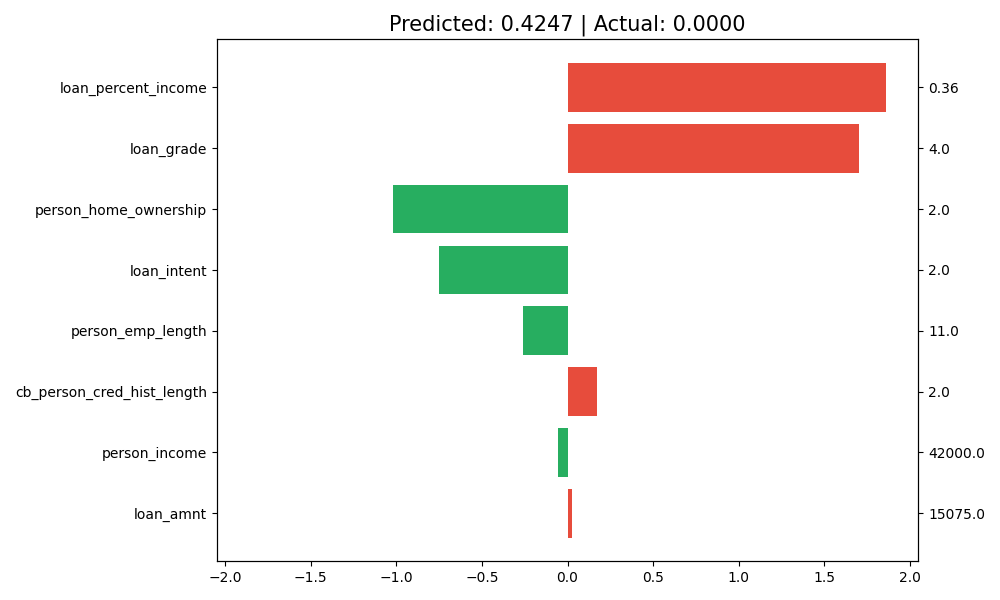

In [45]:
# Compute each features's effect in the final output for on sample
a = exp.model_interpret(model='XGB2', show="local_fi", figsize=(10, 6), original_scale=True, sample_id=100, return_data=True)

In [50]:
a.show_data()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Feature Name,Feature Value,Effect
0,cb_person_default_on_file,1.00,0.0000
1,loan_amnt,15075.00,0.0247
2,person_income,42000.00,-0.0546
3,cb_person_cred_hist_length,2.00,0.1711
4,person_emp_length,11.00,-0.2603
5,loan_intent,2.00,-0.7500
6,person_home_ownership,2.00,-1.0187
7,loan_grade,4.00,1.7011
8,loan_percent_income,0.36,1.8629


In [54]:
0.0247 -0.0546 + 0.1711 - 0.2603 -0.7500- 1.0187 + 1.7011 + 1.8629 -1.9798619443024787

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

-0.3036619443024786

In [59]:
1/(1+np.exp(0.3036619443024786))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

0.42466253543339455

In [39]:
parsed_model = model.parse_model()
list(zip(parsed_model.effect_names_, parsed_model.effect_types_))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

[('person_income', 'numerical'),
 ('person_emp_length', 'numerical'),
 ('loan_grade', 'numerical'),
 ('cb_person_cred_hist_length', 'numerical'),
 ('person_home_ownership', 'numerical'),
 ('loan_intent', 'numerical'),
 ('loan_amnt', 'numerical'),
 ('loan_percent_income', 'numerical'),
 ('person_income x person_home_ownership', 'pairwise'),
 ('person_income x person_emp_length', 'pairwise'),
 ('person_income x loan_intent', 'pairwise'),
 ('person_income x loan_grade', 'pairwise'),
 ('person_income x loan_amnt', 'pairwise'),
 ('person_income x loan_percent_income', 'pairwise'),
 ('person_income x cb_person_cred_hist_length', 'pairwise'),
 ('person_home_ownership x loan_intent', 'pairwise'),
 ('person_home_ownership x loan_grade', 'pairwise'),
 ('person_home_ownership x loan_amnt', 'pairwise'),
 ('person_home_ownership x loan_percent_income', 'pairwise'),
 ('person_emp_length x loan_intent', 'pairwise'),
 ('person_emp_length x loan_grade', 'pairwise'),
 ('person_emp_length x loan_percent_

In [53]:
parsed_model.intercept_

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

-1.9798619443024787

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

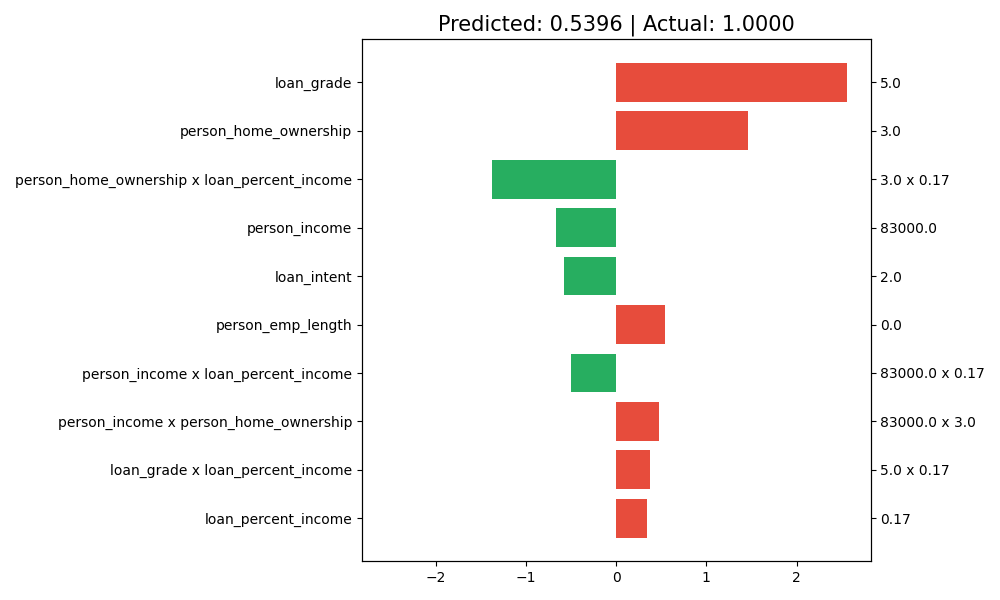

In [88]:
# Compute each features's effect in the final output for on sample
a = exp.model_interpret(model='XGB2', show="local_ei", figsize=(10, 6), original_scale=True, sample_id=1, return_data=True)

In [85]:
a.show_data()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Feature Name,Feature Value,Importance
0,person_income x person_emp_length,"[42000.0, 11.0]",-0.0006
1,person_income x loan_intent,"[42000.0, 2.0]",0.0040
2,person_emp_length x loan_grade,"[11.0, 4.0]",0.0090
3,loan_amnt x loan_percent_income,"[15075.0, 0.36]",-0.0116
4,person_emp_length x loan_percent_income,"[11.0, 0.36]",0.0126
5,person_emp_length x loan_intent,"[11.0, 2.0]",-0.0199
6,loan_intent x cb_person_cred_hist_length,"[2.0, 2.0]",-0.0200
7,person_emp_length x cb_person_cred_hist_length,"[11.0, 2.0]",0.0274
8,person_income x loan_grade,"[42000.0, 4.0]",0.0319
9,loan_intent x loan_percent_income,"[2.0, 0.36]",-0.0364


# *Conformal Predictions*

**Conformal Predictions with MAPIE library**

In [43]:
# Wrapping our trained model
mapie_classifier = MapieClassifier(estimator=model, cv='prefit',method="score", random_state=42)

# Calculating non-conformity score on calibration (Validation) data
mapie_classifier.fit(X_valid, y_valid)

# Error level (coverage target is 1- alpha)
alpha=0.05

# Prediction from the model (y_pred) and conformal sets (pred_set)
y_pred, pred_set = mapie_classifier.predict(X_test, alpha=alpha)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [44]:
# identify the observations where both classes are in the prediction set
for index, obs in enumerate(pred_set.reshape(-1, 2)):
    if int(obs[0]) + int(obs[1]) ==2:
        print('Both classes are in the prediction set for observation {}'.format(index))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Both classes are in the prediction set for observation 7
Both classes are in the prediction set for observation 28
Both classes are in the prediction set for observation 42
Both classes are in the prediction set for observation 44
Both classes are in the prediction set for observation 46
Both classes are in the prediction set for observation 49
Both classes are in the prediction set for observation 51
Both classes are in the prediction set for observation 53
Both classes are in the prediction set for observation 76
Both classes are in the prediction set for observation 78
Both classes are in the prediction set for observation 81
Both classes are in the prediction set for observation 97
Both classes are in the prediction set for observation 99
Both classes are in the prediction set for observation 104
Both classes are in the prediction set for observation 108
Both classes are in the prediction set for observation 126
Both classes are in the prediction set for observation 127
Both classe

In [44]:
# Compute scores for calibration set
calibration_scores = non_conformity_score_prob(model, X_test, y_test)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [45]:
# Assume X_cal, y_cal, X_test are already prepared and the model is trained
result = calculate_prediction_interval_batch(model, X_valid, y_valid, X_test, significance_level=0.05)

print("Prediction Sets (for each observation):", result['prediction_sets'])
print("Probabilities:", result['probabilities'])
print("Non-conformity Scores:", result['scores'])
print("Threshold:", result['threshold'])

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Prediction Sets (for each observation): [[1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 1], [1, 0], [1, 1], [1, 0], [1, 1], [1, 0], [1, 0], [1, 1], [0, 1], [1, 1], [1, 0], [1, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 1], [1, 0], [1, 1], [1, 0], [1, 0], [1, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 1], [0, 1], [1, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 1], [1, 0], [1, 0], [1, 0], [1, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0],

In [47]:
# identify observations where both classes are in the prediction set
both_classes_index = []
for index, obs in enumerate(result['prediction_sets']):
    if obs[0]+obs[1]==2:
        both_classes_index.append(index)
        print('Both classes are in the prediction set for observation {}'.format(index))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Both classes are in the prediction set for observation 7
Both classes are in the prediction set for observation 28
Both classes are in the prediction set for observation 42
Both classes are in the prediction set for observation 44
Both classes are in the prediction set for observation 46
Both classes are in the prediction set for observation 49
Both classes are in the prediction set for observation 51
Both classes are in the prediction set for observation 53
Both classes are in the prediction set for observation 76
Both classes are in the prediction set for observation 78
Both classes are in the prediction set for observation 81
Both classes are in the prediction set for observation 97
Both classes are in the prediction set for observation 99
Both classes are in the prediction set for observation 104
Both classes are in the prediction set for observation 108
Both classes are in the prediction set for observation 126
Both classes are in the prediction set for observation 127
Both classe

**Compute ROC_AUC score without uncertaint predictions**

In [48]:
# Predict

pred_test_excluded = model.predict_proba(X_test.drop(index=both_classes_index))[:, 1]

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [49]:
# Calculate AUC

print('AUC Test:', roc_auc_score(y_test.drop(index=both_classes_index), pred_test_excluded))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

AUC Test: 0.9178211083676229


ROC_AUC score is the same!!! 

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

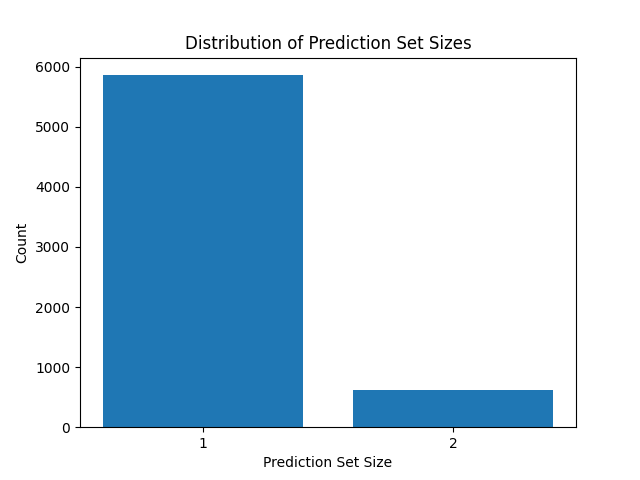

In [51]:
# Plot the distribution of prediction set sizes
set_sizes = [sum(pset) for pset in result['prediction_sets']]
average_set_size  = np.mean(set_sizes)

plt.hist(set_sizes, bins=[1, 2, 3], align='left', rwidth=0.8)
plt.xticks([1, 2])
plt.xlabel("Prediction Set Size")
plt.ylabel("Count")
plt.title("Distribution of Prediction Set Sizes")
plt.show()

In [53]:
# Print average prediction set size
print(f"Average Prediction Set Size: {average_set_size:.2f}")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Average Prediction Set Size: 1.10


In [54]:
# Calculate coverage rate of conformal predictions, that indicates how many of the true labels are in the prediction set
coverage = sum(
    true_label in pred_set
    for pred_set, true_label in zip(result['prediction_sets'], y_test)
) / len(y_test)

print(f"Coverage: {coverage:.2%}")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Coverage: 94.39%


In [55]:
# XGB2Classifier predicted classes for test set, threshold = 0.3
predicted_classes = (pred_test>0.3).astype(int)

# Conformal predictions for test set
prediction_set = []
for i in result['prediction_sets']:
    if i[0]+i[1]==2:
        prediction_set.append(2)
    else:
        prediction_set.append(np.argmax(i))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Identify how much portion are identified correcltly by conformal predictions

In [61]:
pred_analysis = pd.DataFrame({'PREDICTED': predicted_classes, 'CONFORMAL_PREDICTIONS': prediction_set, 'ACTUAL': y_test})

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [62]:
# Accuracy of model's predicted calsses
accuracy_score(pred_analysis['ACTUAL'], pred_analysis['PREDICTED'])

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

0.8991363355953116

In [63]:
pred_analysis.info()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6484 entries, 0 to 6483
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   PREDICTED              6484 non-null   int32
 1   CONFORMAL_PREDICTIONS  6484 non-null   int64
 2   ACTUAL                 6484 non-null   int64
dtypes: int32(1), int64(2)
memory usage: 126.8 KB


In [64]:
# Missciassified observations
tmp = pred_analysis[pred_analysis['PREDICTED']!=pred_analysis['ACTUAL']]

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [68]:
# 46 % are identified as two classes in the prediction set
pred_analysis[pred_analysis['PREDICTED']!=pred_analysis['ACTUAL']]['CONFORMAL_PREDICTIONS'].value_counts(normalize=True)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

0    0.518349
2    0.460245
1    0.021407
Name: CONFORMAL_PREDICTIONS, dtype: float64

In [69]:
tmp.groupby(['ACTUAL','CONFORMAL_PREDICTIONS']).size().to_frame('COUNT')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

COUNT
ACTUAL CONFORMAL_PREDICTIONS       
0      1                         14
       2                        287
1      0                        339
       2                         14